In [1]:
import sys

In [2]:
sys.path.insert(0, '/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data')

In [3]:
sys.path

['/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data',
 '',
 '/home/joe/PythonRoot/anaconda3/envs/riskylobster/lib/python36.zip',
 '/home/joe/PythonRoot/anaconda3/envs/riskylobster/lib/python3.6',
 '/home/joe/PythonRoot/anaconda3/envs/riskylobster/lib/python3.6/lib-dynload',
 '/home/joe/PythonRoot/anaconda3/envs/riskylobster/lib/python3.6/site-packages',
 '/home/joe/PythonRoot/anaconda3/envs/riskylobster/lib/python3.6/site-packages/IPython/extensions',
 '/home/joe/.ipython']

In [4]:
sys.path.remove('')

In [5]:
import csv
from time import sleep

In [6]:
from fin_data import DailyTimeSeries
from fracdiff import FractionalDifferentiation as fd

import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


In [23]:
def generate_df_fracdiff_target(symbol, return_type='generator', shift=1):
    # Ininialize class
    dts = DailyTimeSeries(symbol)
    df = dts.initiate()
    funs = ['totalrevenue',  'totalcostofrevenue', 'totalgrossprofit', 'totalpretaxincome', 'weightedavebasicdilutedsharesos', 'cashdividendspershare']
    techs = ['SMA', 'WMA', 'STOCH', 'ROC', 'AROON']
    macros = ['housing_index', 'confidence_index', 'trade_index', 'longterm_rates', 'shortterm_rates']
    df = dts.add_fundamentals(df, funs)
    sleep(5)
    df = dts.add_technicals(techs, df)
    sleep(15)
    df = dts.add_macro(df, macros)
    todrop = []
    for col in df.columns:
        if df[col].isnull().sum()/len(df) >  .25:
            print('{} is missing '.format(col), df[col].isnull().sum())
            print('{} dropped'.format(col))
            todrop.append(col)

    df = df.drop(labels=todrop, axis=1)
    df = df.dropna(axis=0)
    
    if str(symbol + '_adjusted_close') in df.columns:
        df['target'] = fd.frac_diff_ffd(df[[str(symbol + '_adjusted_close')]], .35).shift(-1)[str(symbol + '_adjusted_close')]
    else:
        df['target'] = fd.frac_diff_ffd(df[[str(symbol + '_close')]], .35).shift(-1)[str(symbol + '_close')]

    df = df.fillna(value=0)
    X = df.drop(columns='target')
    y = df[['target']].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    shuffle=False)

    scaler = MinMaxScaler()
    scaler.fit(X_train)


    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    if return_type == 'generator':
        train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=30,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=30)

        test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                                  length=30, 
                                                  sampling_rate=1,
                                                  stride=1,
                                                  batch_size=30)
        
        return(train_data_generator, test_data_generator)
    
    elif return_type == 'Xy_trte':
        return(X_train, X_test, y_train, y_test)
    
    elif return_type == 'df':
        return(df)
    else:
        return(df)


In [8]:
csv500 = open('constituents_csv.csv','r')
sp500 = []

next(csv500)

for sym in csv.reader(csv500, delimiter=','):
    sp500.append(sym[0])

In [ ]:
data_dict = {}

In [25]:
sp500[12:14]

['AMG', 'AFL']

In [26]:
# Note: attempting to get data from alpha-vantage for 'AES' causes api error
# Todo: wrap in try except in case of similar errors.
for sym in sp500[12:16]:
    if sym not in data_dict.keys():
        X_train, X_test, y_train, y_test = generate_df_fracdiff_target(sym, return_type='Xy_trte', shift=1)
        data_dict[sym] = [X_train, X_test, y_train, y_test]
        sleep(30)
    else:
        print('Already have data for ', sym)

################################################################### 
 Ticker:  AMG 
 Last Refreshed:  2019-09-19 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  AMG 
 Fundamentals Retrieved:  ['AMG_open' 'AMG_high' 'AMG_low' 'AMG_close' 'AMG_adjusted_close'
 'AMG_volume' 'AMG_dividend_amount' 'AMG_totalrevenue'
 'AMG_totalcostofrevenue' 'AMG_totalgrossprofit' 'AMG_totalpretaxincome'
 'AMG_weightedavebasicdilutedsharesos' 'AMG_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AMG 
 Retrieved Data Start Date:  2010-08-09 
 Retrieved Data End Date:  2019-08-09 
 Data Retrieved:  ['AMG_totalrevenue', 'AMG_totalcostofrevenue', 'AMG_totalgrossprofit', 'AMG_totalpretaxincome', 'AMG_weightedavebasicdiluted

/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  4227
8_Wk_DR dropped
8_Wk_CE is missing  4227
8_Wk_CE dropped
52_Wk_DR is missing  1610
52_Wk_DR dropped
52_Wk_CE is missing  1610
52_Wk_CE dropped


/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


################################################################### 
 Ticker:  AFL 
 Last Refreshed:  2019-09-19 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  AFL 
 Fundamentals Retrieved:  ['AFL_open' 'AFL_high' 'AFL_low' 'AFL_close' 'AFL_adjusted_close'
 'AFL_volume' 'AFL_dividend_amount' 'AFL_totalrevenue'
 'AFL_totalcostofrevenue' 'AFL_totalgrossprofit' 'AFL_totalpretaxincome'
 'AFL_weightedavebasicdilutedsharesos' 'AFL_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AFL 
 Retrieved Data Start Date:  2009-08-07 
 Retrieved Data End Date:  2019-07-26 
 Data Retrieved:  ['AFL_totalrevenue', 'AFL_totalcostofrevenue', 'AFL_totalgrossprofit', 'AFL_totalpretaxincome', 'AFL_weightedavebasicdiluted

/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  4227
8_Wk_DR dropped
8_Wk_CE is missing  4227
8_Wk_CE dropped
52_Wk_DR is missing  1610
52_Wk_DR dropped
52_Wk_CE is missing  1610
52_Wk_CE dropped


/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


################################################################### 
 Ticker:  A 
 Last Refreshed:  2019-09-19 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  A 
 Fundamentals Retrieved:  ['A_open' 'A_high' 'A_low' 'A_close' 'A_adjusted_close' 'A_volume'
 'A_dividend_amount' 'A_totalrevenue' 'A_totalcostofrevenue'
 'A_totalgrossprofit' 'A_totalpretaxincome'
 'A_weightedavebasicdilutedsharesos' 'A_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  A 
 Retrieved Data Start Date:  2009-10-05 
 Retrieved Data End Date:  2019-08-30 
 Data Retrieved:  ['A_totalrevenue', 'A_totalcostofrevenue', 'A_totalgrossprofit', 'A_totalpretaxincome', 'A_weightedavebasicdilutedsharesos', 'A_cashdividendspershare'] 
 ##

/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  4227
8_Wk_DR dropped
8_Wk_CE is missing  4227
8_Wk_CE dropped
52_Wk_DR is missing  1610
52_Wk_DR dropped
52_Wk_CE is missing  1610
52_Wk_CE dropped


/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


################################################################### 
 Ticker:  APD 
 Last Refreshed:  2019-09-19 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################
################################################################### 
 Ticker:  APD 
 Fundamentals Retrieved:  ['APD_open' 'APD_high' 'APD_low' 'APD_close' 'APD_adjusted_close'
 'APD_volume' 'APD_dividend_amount' 'APD_totalrevenue'
 'APD_totalcostofrevenue' 'APD_totalgrossprofit' 'APD_totalpretaxincome'
 'APD_weightedavebasicdilutedsharesos' 'APD_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  APD 
 Retrieved Data Start Date:  2009-07-24 
 Retrieved Data End Date:  2019-07-25 
 Data Retrieved:  ['APD_totalrevenue', 'APD_totalcostofrevenue', 'APD_totalgrossprofit', 'APD_totalpretaxincome', 'APD_weightedavebasicdiluted

/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################
8_Wk_DR is missing  4227
8_Wk_DR dropped
8_Wk_CE is missing  4227
8_Wk_CE dropped
52_Wk_DR is missing  1610
52_Wk_DR dropped
52_Wk_CE is missing  1610
52_Wk_CE dropped


/home/joe/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


In [20]:
data_dict.keys()

dict_keys(['MMM', 'AOS'])

In [27]:
for k in data_dict.keys():
    for i in data_dict[k]:
        print(i.shape)

(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(1208, 34)
(303, 34)
(1208, 1)
(303, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)
(3439, 32)
(860, 32)
(3439, 1)
(860, 1)


In [32]:
for data in data_dict:
    plt.plot(data_dict[data][2])
    plt.plot(data_dict[data][3])

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


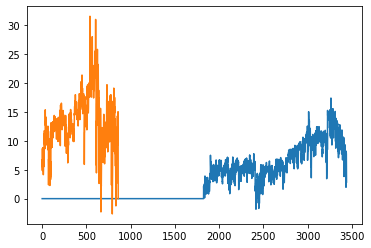

In [33]:
    plt.plot(data_dict['MMM'][2])
    plt.plot(data_dict['MMM'][3])

In [34]:
data_dict['MMM'][2]

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [7.69445422],
       [5.57765271],
       [2.86909068]])

In [38]:
for data in data_dict:
    print(len(data_dict[data][2]) - np.count_nonzero(data_dict[data][2]))

1824
1824
1824
1208
1824
1824
1824
1824
1824
1824
1824
1824
1824
1824
1824
